# Welcome to the tutorial about mypackage!

## Data Processing
### Loading Data
    Load the dataset from the specified file path and perform initial formatting.

In [1]:
from pygroupf.data_processing import *

Columns in dataset: Index(['age', 'sex', 'job', 'housing', 'saving_accounts', 'checking_account',
       'credit_amount', 'duration', 'purpose'],
      dtype='object')
Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.500 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=3;, score=1.000 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=3;, score=1.000 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.250 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.000 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estim

In [2]:
# Load data, remove unnamed index column if exists and standardize column names 
data = load_data("data/german_credit_data.csv")
data.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


### Define Column Types and Mapping

In [3]:
# Define column types
categorical_cols = [
    "Sex",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose",
]
numerical_cols = ["Age", "Job", "Credit amount", "Duration"]

# Define mapping of categorical values to numerical values
mapping = {
    "Sex": {"male": 1, "female": 0, "unknown": -1},
    "Housing": {"own": 2, "free": 1, "rent": 0, "unknown": -1},
    "Saving accounts": {
        "unknown": 0,
        "little": 1,
        "moderate": 2,
        "quite rich": 3,
        "rich": 4,
    },
    "Checking account": {"unknown": 0, "little": 1, "moderate": 2, "rich": 3},
}

### Clean and preprocess the dataset
    Handles missing values differently for categorical and numerical columns:
        1. Categorical columns: Filled with 'unknown'
        2. Numerical columns: Converted to numeric type and filled with median

In [4]:
# clean and preprocess data
cleaned_data = clean_data(data, categorical_cols, numerical_cols)

### Encoding Data
    Encoding categorical columns using specified numerical mappings.

In [5]:
# Encode categorical data
encoder = DataEncoder(mapping)
encoded_data = encoder.encode(cleaned_data)

In [6]:
# Save processed data
save_processed_data(encoded_data)

# Display the processed data
processed_data = pd.read_csv("data/processed_credit_data.csv")
processed_data.head()

Data processing completed successfully! File saved to data\processed_credit_data.csv


,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose
0,67,1,2,2,0,1,1169,6,radio/TV
1,22,0,2,2,1,2,5951,48,radio/TV
2,49,1,1,2,1,0,2096,12,education
3,45,1,2,1,1,1,7882,42,furniture/equipment
4,53,1,2,1,1,1,4870,24,car


## Credit Risk Modeling with Random Forest
### Loading Processed Data
    by loading the pre-processed credit data that has gone through cleaning


In [7]:
# Import all modeling functions
import pandas as pd
from pygroupf.modeling import *

# Load processed data
data = pd.read_csv("data/processed_credit_data.csv")
print("Data shape:", data.shape)
data.head()

Data shape: (1000, 9)


,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose
0,67,1,2,2,0,1,1169,6,radio/TV
1,22,0,2,2,1,2,5951,48,radio/TV
2,49,1,1,2,1,0,2096,12,education
3,45,1,2,1,1,1,7882,42,furniture/equipment
4,53,1,2,1,1,1,4870,24,car


### Feature Engineering
    need to:
        1.Encode categorical variables using one-hot encoding
        2.Create our target variable ('good_credit')

In [8]:
# One-Hot Encoding for categorical features
categorical_cols = ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Create binary target variable
# Good credit = customers with credit > 10,000 and age > 30
data['good_credit'] = ((data['credit_amount'] > 10000) & (data['age'] > 30)).astype(int)
print("Class distribution:\n", data['good_credit'].value_counts())

Class distribution:
 good_credit
0    975
1     25
Name: count, dtype: int64


### Model Training
#### Train-Test Split
    We split the data into 80% training and 20% test sets.

In [9]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop(columns=['good_credit'])
y = data['good_credit']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 800, Test samples: 200


#### Hyperparameter Tuning
    We use GridSearchCV to find the optimal Random Forest parameters.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Parameter grid for tuning
param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "n_estimators": [3, 5, 10, 25, 50, 150],
    "max_features": [4, 7, 15, 20]
}

# Initialize and fit GridSearch
rf = RandomForestClassifier(random_state=2)
grid_search = GridSearchCV(
    rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='recall', 
    verbose=1
)
grid_search.fit(X_train, y_train)

# Show best parameters
print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'max_depth': 3, 'max_features': 15, 'n_estimators': 25}
Best recall score: 0.9199999999999999


### Model Evaluation
#### Training Final Model
    We train the final model using the best parameters found.

In [11]:
# Train model with optimal parameters
best_rf = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=2
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=15, n_estimators=25,
                       random_state=2)

#### Performance Metrics
    We evaluate on the test set using:Accuracy, Confusion Matrix, F2 Score (giving more weight to recall)

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score

# Make predictions
y_pred = best_rf.predict(X_test)

# Calculate metrics
print("Test Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))

Test Set Performance:
Accuracy: 1.0
Confusion Matrix:
 [[198   0]
 [  0   2]]
F2 Score: 1.0


### Feature Importance
    to understand which features most impact predictions.

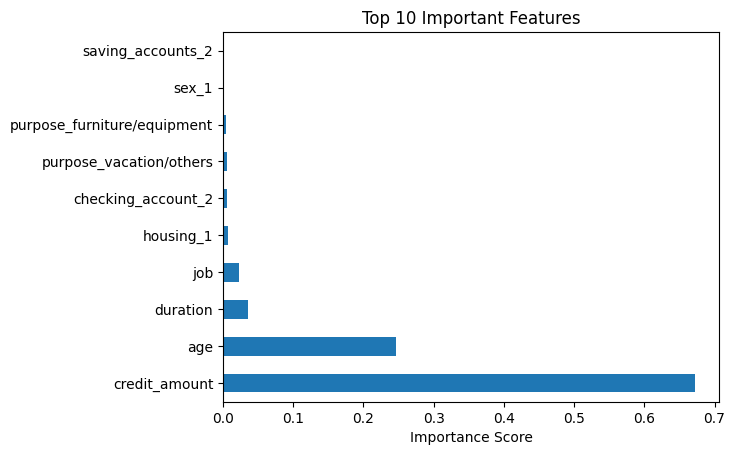

In [13]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot top 10 features
feat_imp[:10].plot(kind='barh')
plt.title('Top 10 Important Features')
plt.xlabel('Importance Score')
plt.show()

## Analysis

In [14]:
from pygroupf.analysis import DataAnalyzer

### Define Scoring Rules
    1. Define scoring rules for different fields
    2. Define risk levels based on total score

In [15]:
# Define scoring rules for different fields
scoring_rules = {
    'Age': [
        {'condition': lambda x: x < 20 or x > 70, 'score': 15},
        {'condition': lambda x: 20 <= x < 25 or 60 < x <= 70, 'score': 10},
        {'condition': lambda x: 25 <= x < 30 or 50 < x <= 60, 'score': 5}
    ],
    'Sex': {'male': 2, 'female': 0, 'unknown': 1},
    'Job': {0: 15, 1: 10, 2: 5, 3: 1},
    'Housing': {0: 15, 1: 10, 2: 5},
    'Saving accounts': {
        'default': lambda x: (4 - x) * 3 if x > 0 else 10,
        'specific': {0: 10}
    },
    'Checking account': {
        'default': lambda x: (3 - x) * 4 if x > 0 else 10,
        'specific': {0: 10}
    },
    'Credit amount': [
        {'threshold': 8000, 'score': 15},
        {'threshold': 5000, 'score': 10},
        {'threshold': 2000, 'score': 5}
    ],
    'Duration': [
        {'threshold': 36, 'score': 15},
        {'threshold': 24, 'score': 10},
        {'threshold': 12, 'score': 5}
    ],
    'Purpose': {
        'business': 10,
        'education': 10,
        'unknown': 8,
        'car': 5,
        'furniture/equipment': 5,
        'radio/TV': 3,
        'domestic appliances': 3,
        'repairs': 3,
        'vacation/others': 3
    }
}

# Define risk levels based on total score
risk_levels = [
    (70, "High risk"),
    (50, "Medium-high risk"),
    (30, "Medium-low risk"),
    (0, "Low risk")
]

### Analyzes Data
    Analyzes credit data to calculate risk scores and levels using configurable rules.

In [16]:
# data analysis
# processed_data = pd.read_csv("data/processed_credit_data.csv")
analyzer = DataAnalyzer(processed_data, scoring_rules, risk_levels)

# generate and save risk report
risk_report = analyzer.generate_risk_report() 
analyzer.save_risk_report("data/risk_report.csv")

Risk report saved to data/risk_report.csv


In [17]:
# Display the risk report
risk_report.head()

,customer_id,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk_score,risk_level
0,1,67,1,2,2,0,1,1169,6,radio/TV,41,Medium-low risk
1,2,22,0,2,2,1,2,5951,48,radio/TV,61,Medium-high risk
2,3,49,1,1,2,1,0,2096,12,education,49,Medium-low risk
3,4,45,1,2,1,1,1,7882,42,furniture/equipment,62,Medium-high risk
4,5,53,1,2,1,1,1,4870,24,car,52,Medium-high risk


## Visualization
    We use DataVisualizer to generate two plots:
    1. a heatmap showing the correlation between all variables
    2. the distribution of risk levels among customers

In [18]:
from pygroupf.visualization import DataVisualizer

In [19]:
# generat plots and save images
visualizer = DataVisualizer('data/risk_report.csv')
visualizer.visualize_all()

Heatmap saved to image/heatmap.png
Risk level distribution plot saved to image/risk_distribution.png
All visualizations have been generated and saved to the 'image' folder.


In [20]:
from IPython.display import Image

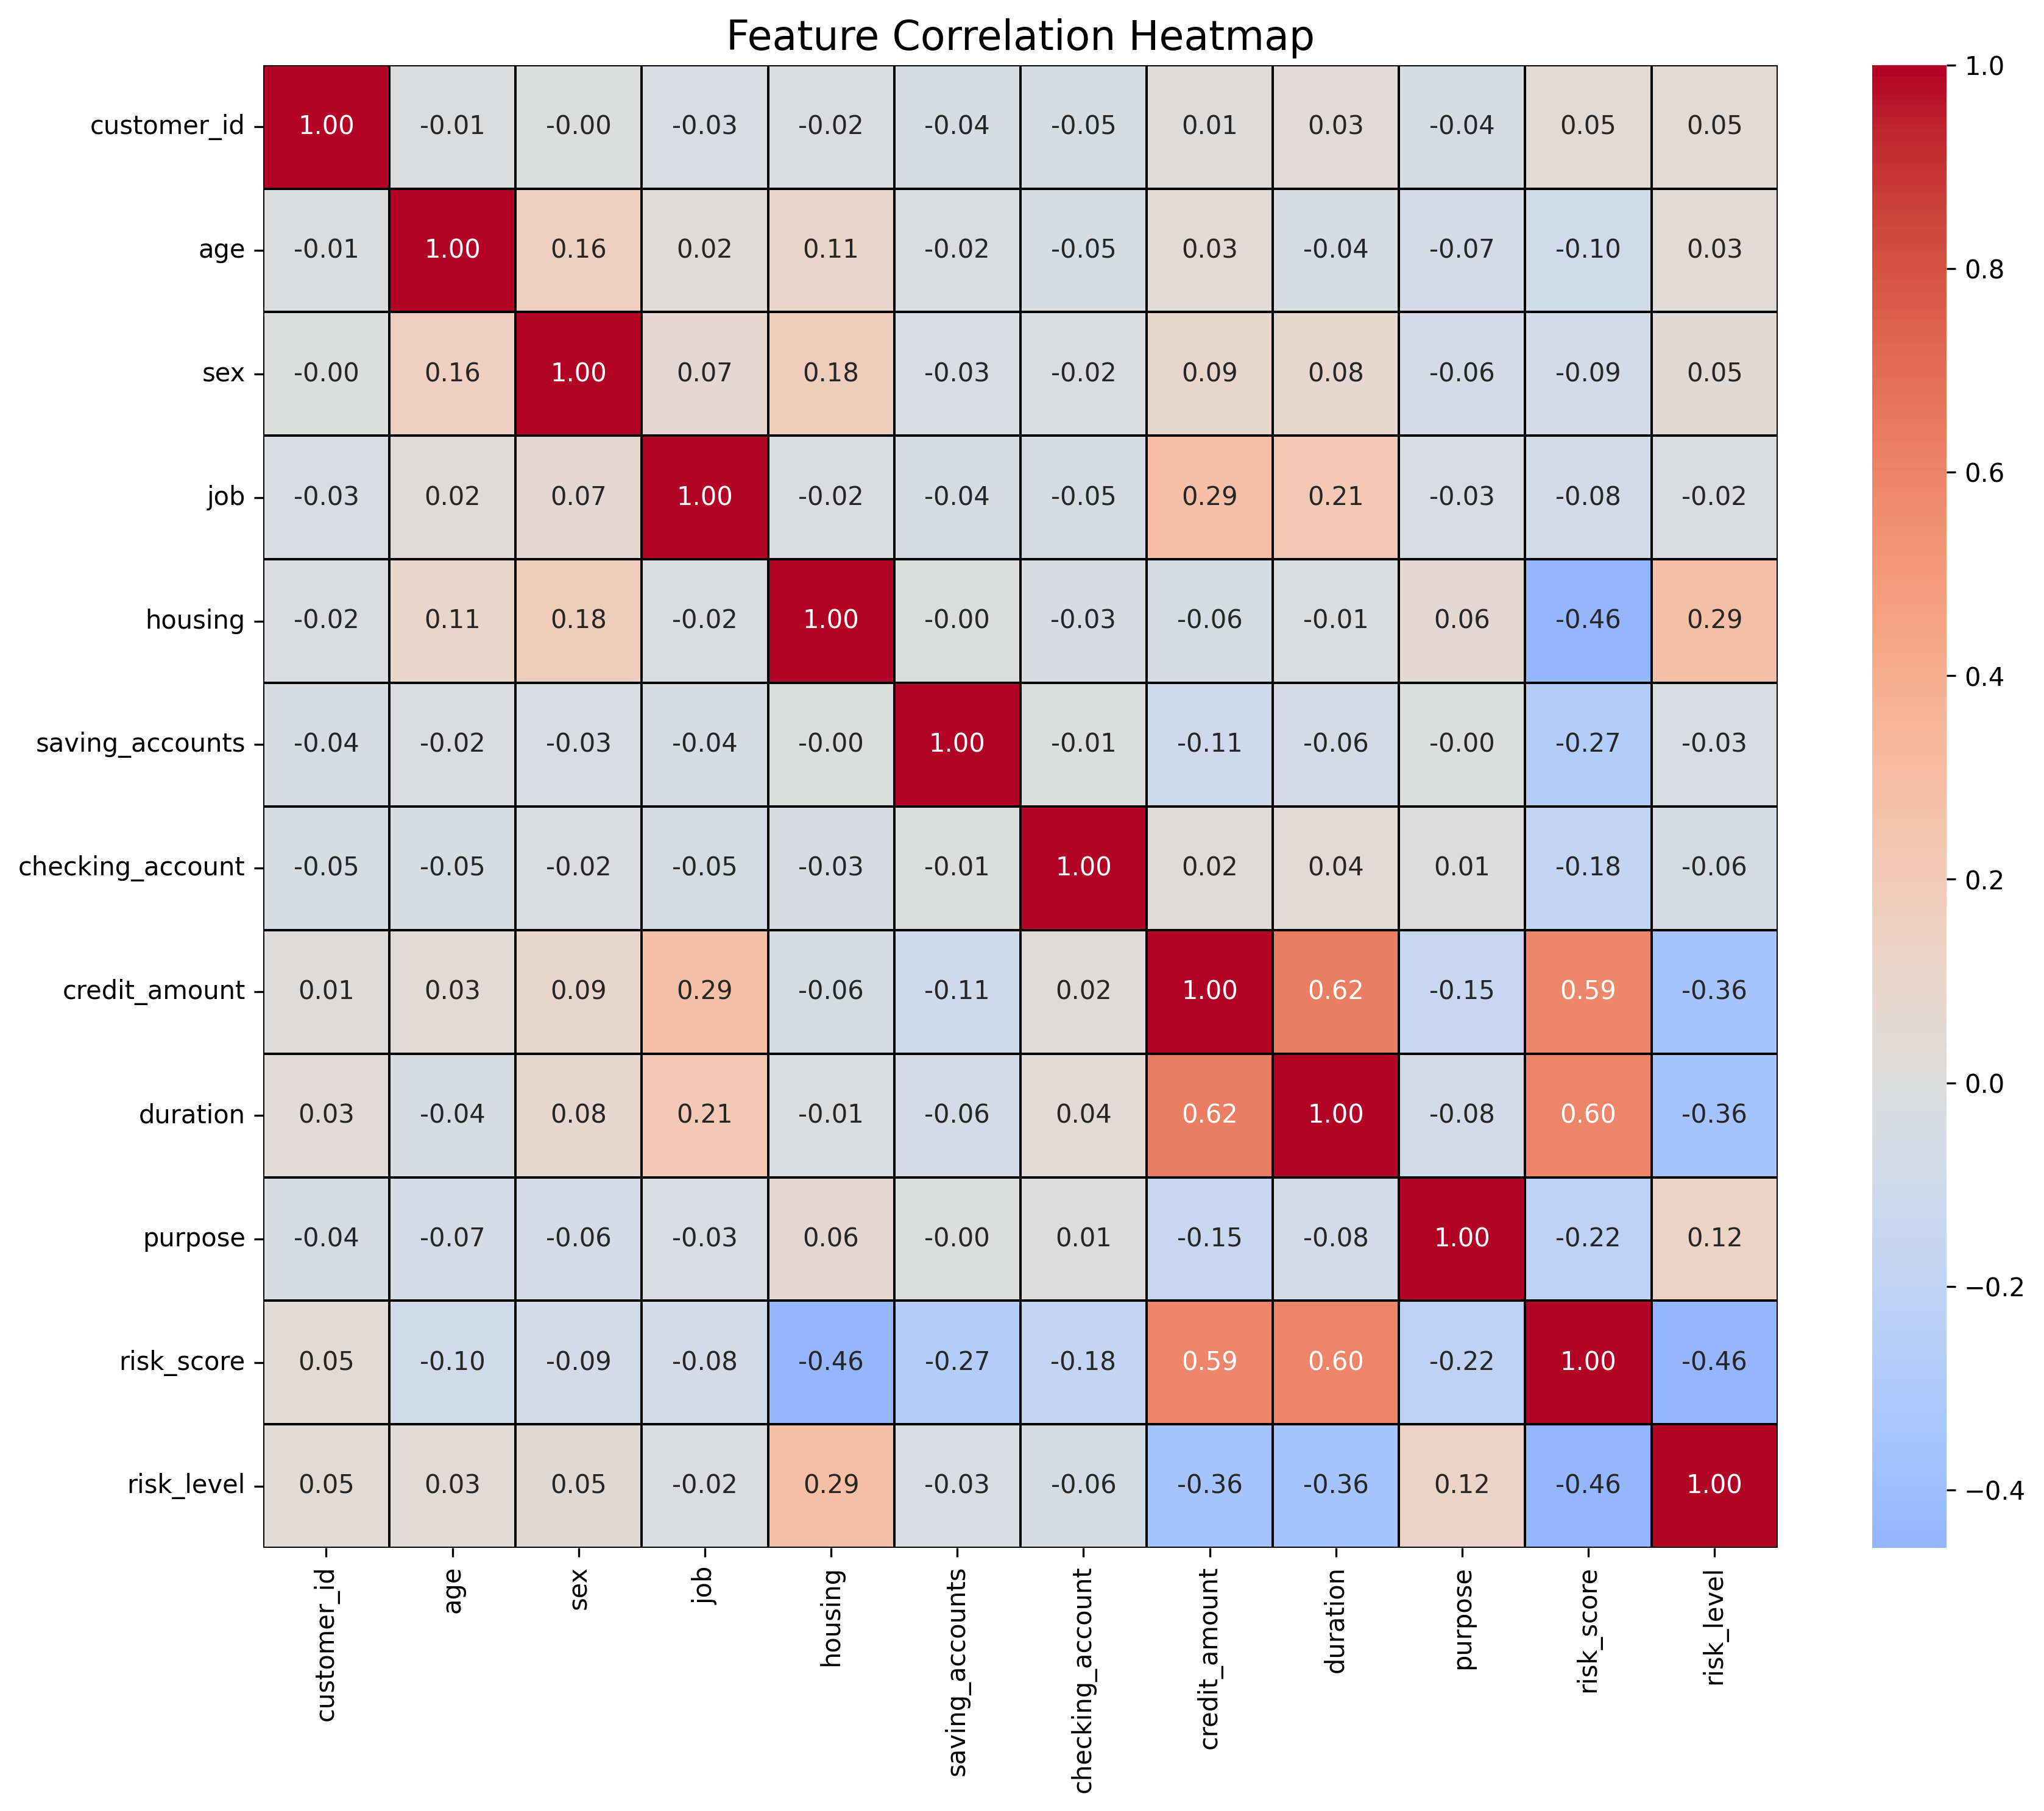

In [21]:
# show image heatmap
Image(filename="image/heatmap.png", width=600)  

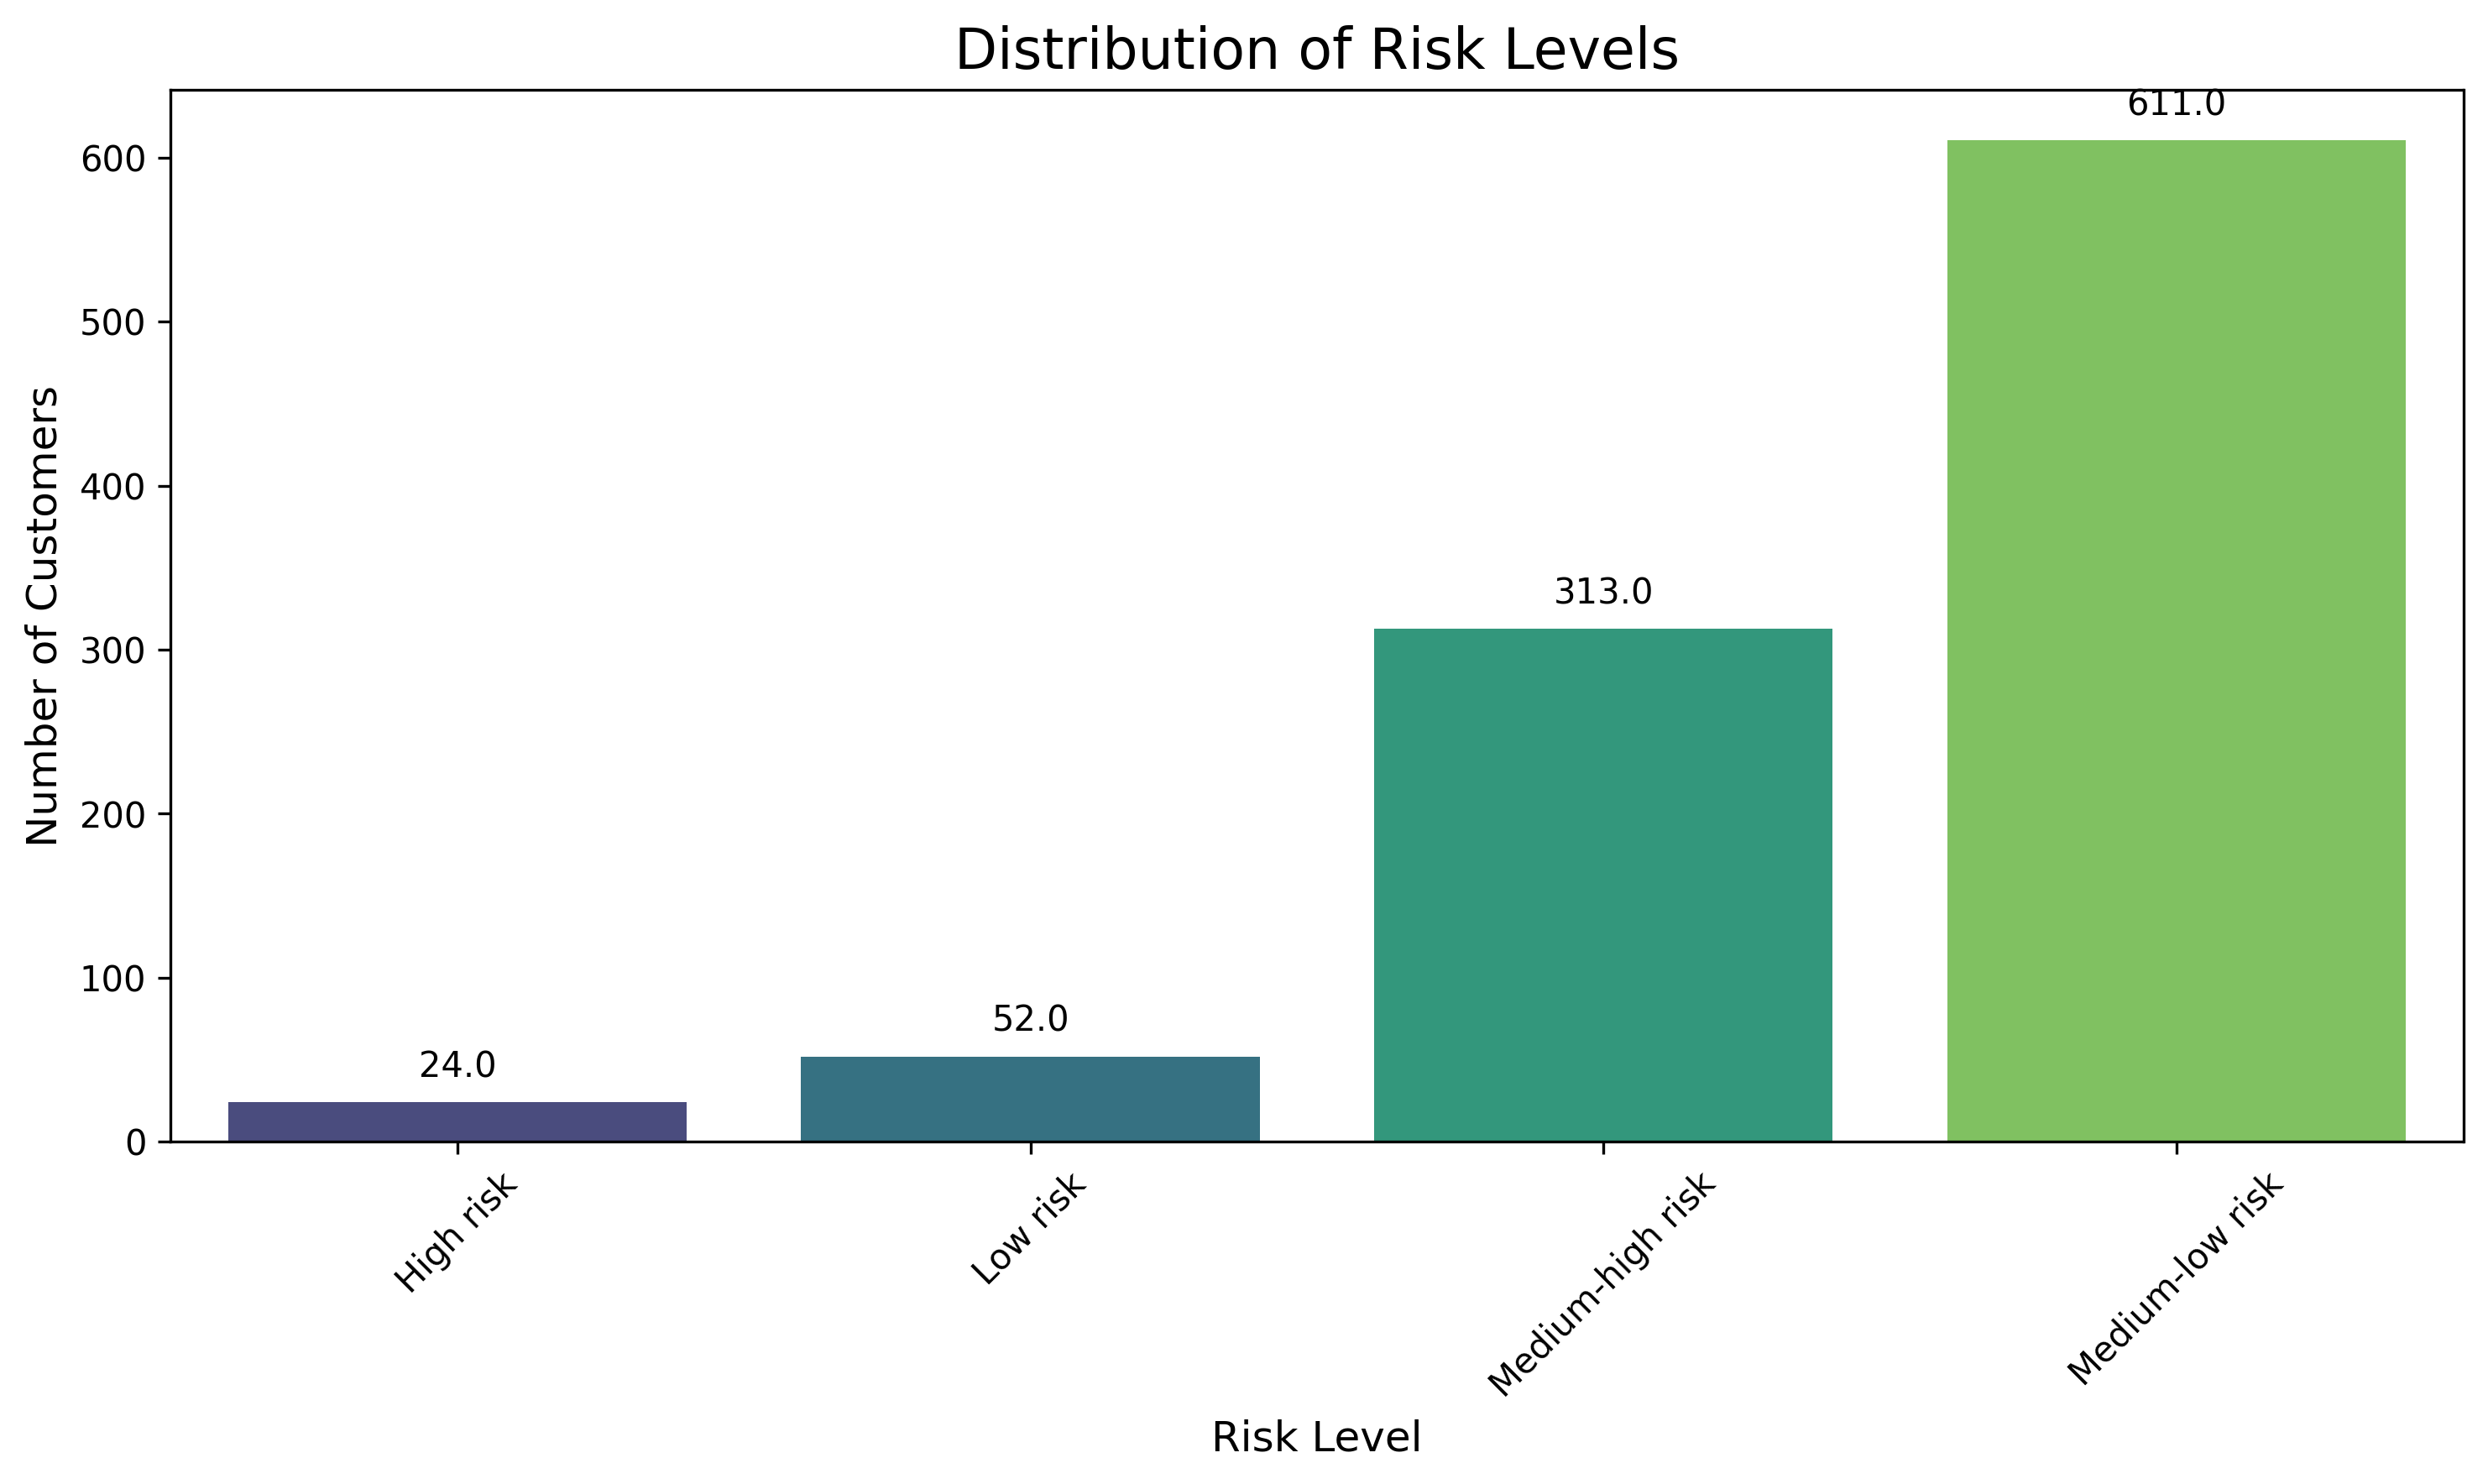

In [22]:
# show image risk_distribution
Image(filename="image/risk_distribution.png", width=600)